In [1]:
import json
import numpy as np
import glob
import os
import anndata

import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import pandas as pd
import json

from sklearn.metrics import pairwise_distances

from dredFISH.Utils.__init__plots import *
from dredFISH.Utils import basicu 
from dredFISH.Utils.miscu import order_by_hc
from dredFISH.Utils import designu
from dredFISH.Design import data_loader_scrna 

import importlib
# config = importlib.import_module("dredfish_processing_config")
# pmat_cols = [bit[0].split('_')[0] for bit in config.bitmap[:24]]

importlib.reload(data_loader_scrna)
importlib.reload(designu)

<module 'dredFISH.Utils.designu' from '/bigstore/GeneralStorage/fangming/projects/dredfish/packages/dredFISH/dredFISH/Utils/designu.py'>

In [2]:
device = torch.device('cpu')
torch.manual_seed(0) # reproduciability

In [3]:
# all data
tst_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=50, #00,
)
# get the datasize the second time
tst_dataloader = data_loader_scrna.load_Allen_data(
    datasetkey='smrt', 
    keyX='counts', keyY='l3_code', keyYcat='l3_cat', 
    batch_size=len(tst_dataloader.dataset),
)

f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna', 'gidx_cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts_idx = torch.load(f)
f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna',      'cnstrnts_pshop_mm10_isoflat.pt')
cnstrnts = torch.load(f)

n_gns = len(cnstrnts) # trn_dataloader.dataset.X.shape[1] # number of genes
n_cat = len(tst_dataloader.dataset.Ycat) # number of clusters
genes_data = tst_dataloader.dataset.data['genes'][:] #.Genes
genes_cnst = genes_data[cnstrnts_idx]
print(genes_data.shape, genes_cnst.shape)

(45768,) (23282,)


In [4]:
%%time
# validation dataset
ftrs_all, clsts = next(iter(tst_dataloader))
ftrs_all = ftrs_all.float()#.numpy() # all features
clsts = clsts.long().numpy()

ftrs = basicu.libsize_norm(ftrs_all.numpy(), scale=1e6)
logftrs = np.log10(ftrs+1)

print(ftrs_all.shape, clsts.shape)

torch.Size([73347, 45768]) (73347,)
CPU times: user 11min 16s, sys: 6min 15s, total: 17min 32s
Wall time: 10min 17s


In [5]:
# get the NN genes and constraints (for old DPNMF design)
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/genes.npy' 
nngenes = np.load(f)
f = '/bigstore/binfo/mouse/Brain/DRedFISH/Allen_V3_Reference/10X/probe_constraints.npy'
nngene_cnstrnts = np.load(f)
assert len(nngene_cnstrnts) == len(nngenes)
print(nngene_cnstrnts.shape)

(10861,)


In [6]:
# DPNMF probe set
f = "/bigstore/GeneralStorage/fangming/projects/dredfish/data/dpnmf.csv"
pmat = pd.read_csv(f, index_col=0) # [pmat_cols]
dpnmfgenes = pmat.index.values # new

In [7]:
dpnmfgenes.shape, nngenes.shape

((9711,), (10861,))

In [8]:
# select only those existed in data
def get_genes_idx(genes, genes_data):
    genes_comm = np.intersect1d(genes, genes_data)
    genes_idx = basicu.get_index_from_array(genes_data, genes_comm)
    return genes_comm, genes_idx

In [9]:
a = dpnmfgenes
b = nngenes
c = genes_cnst
print(a.shape, b.shape, c.shape)
a, a_idx = get_genes_idx(a, genes_data)
b, b_idx = get_genes_idx(b, genes_data)
c, c_idx = get_genes_idx(c, genes_data)
print(a.shape, b.shape, c.shape)

ab_idx = np.intersect1d(a_idx, b_idx)
ac_idx = np.intersect1d(a_idx, c_idx)
bc_idx = np.intersect1d(b_idx, c_idx)
a_unqidx = np.array([i for i in a_idx if i not in ab_idx])
b_unqidx = np.array([i for i in b_idx if i not in ab_idx])
print(ab_idx.shape, a_unqidx.shape, b_unqidx.shape)
print(ac_idx.shape, bc_idx.shape)

(9711,) (10861,) (23282,)
(9174,) (10861,) (23282,)
(5467,) (3707,) (5394,)
(8923,) (10846,)


In [11]:
genes2_mean = np.mean(ftrs, axis=0)
genes2_stdv = np.std(ftrs, axis=0)
genes2_var = genes2_stdv**2
genes2_varmeanratio = genes2_var/np.clip(genes2_mean, 1e-10, None)

In [32]:
cond = genes2_mean[c_idx] > 1 #np.log10(1+1)
# get the new set
genes_sel = genes_data[c_idx][cond]
s, s_idx = get_genes_idx(genes_sel, genes_data)
print(cond.sum(), genes_sel.shape, s_idx.shape)

as_idx = np.intersect1d(a_idx, s_idx)
bs_idx = np.intersect1d(b_idx, s_idx)
print(as_idx.shape, bs_idx.shape)

13489 (13489,) (13489,)
(8763,) (7897,)


In [33]:
# compare all sets
len(np.intersect1d(a_idx, s_idx)), len(np.intersect1d(b_idx, s_idx))

(8763, 7897)

In [45]:
# f = os.path.join('/bigstore/GeneralStorage/fangming/projects/dredfish/data/', 'rna',      'pshop_smart_full_cpm1_genes_13k_oct13_2022.txt')
# print(f)
# np.savetxt(f, s, fmt='%s')

/bigstore/GeneralStorage/fangming/projects/dredfish/data/rna/pshop_smart_full_cpm1_genes_13k_oct13_2022.txt


In [ ]:
# !head $f
# !tail $f
# !wc -l 

0610009B22Rik
0610009E02Rik
0610009L18Rik
0610010F05Rik
0610010K14Rik
0610012G03Rik
0610030E20Rik
0610040B10Rik
0610040F04Rik
0610040J01Rik
Zw10
Zwilch
Zwint
Zxda
Zxdb
Zxdc
Zyg11b
Zyx
Zzef1
Zzz3
^C


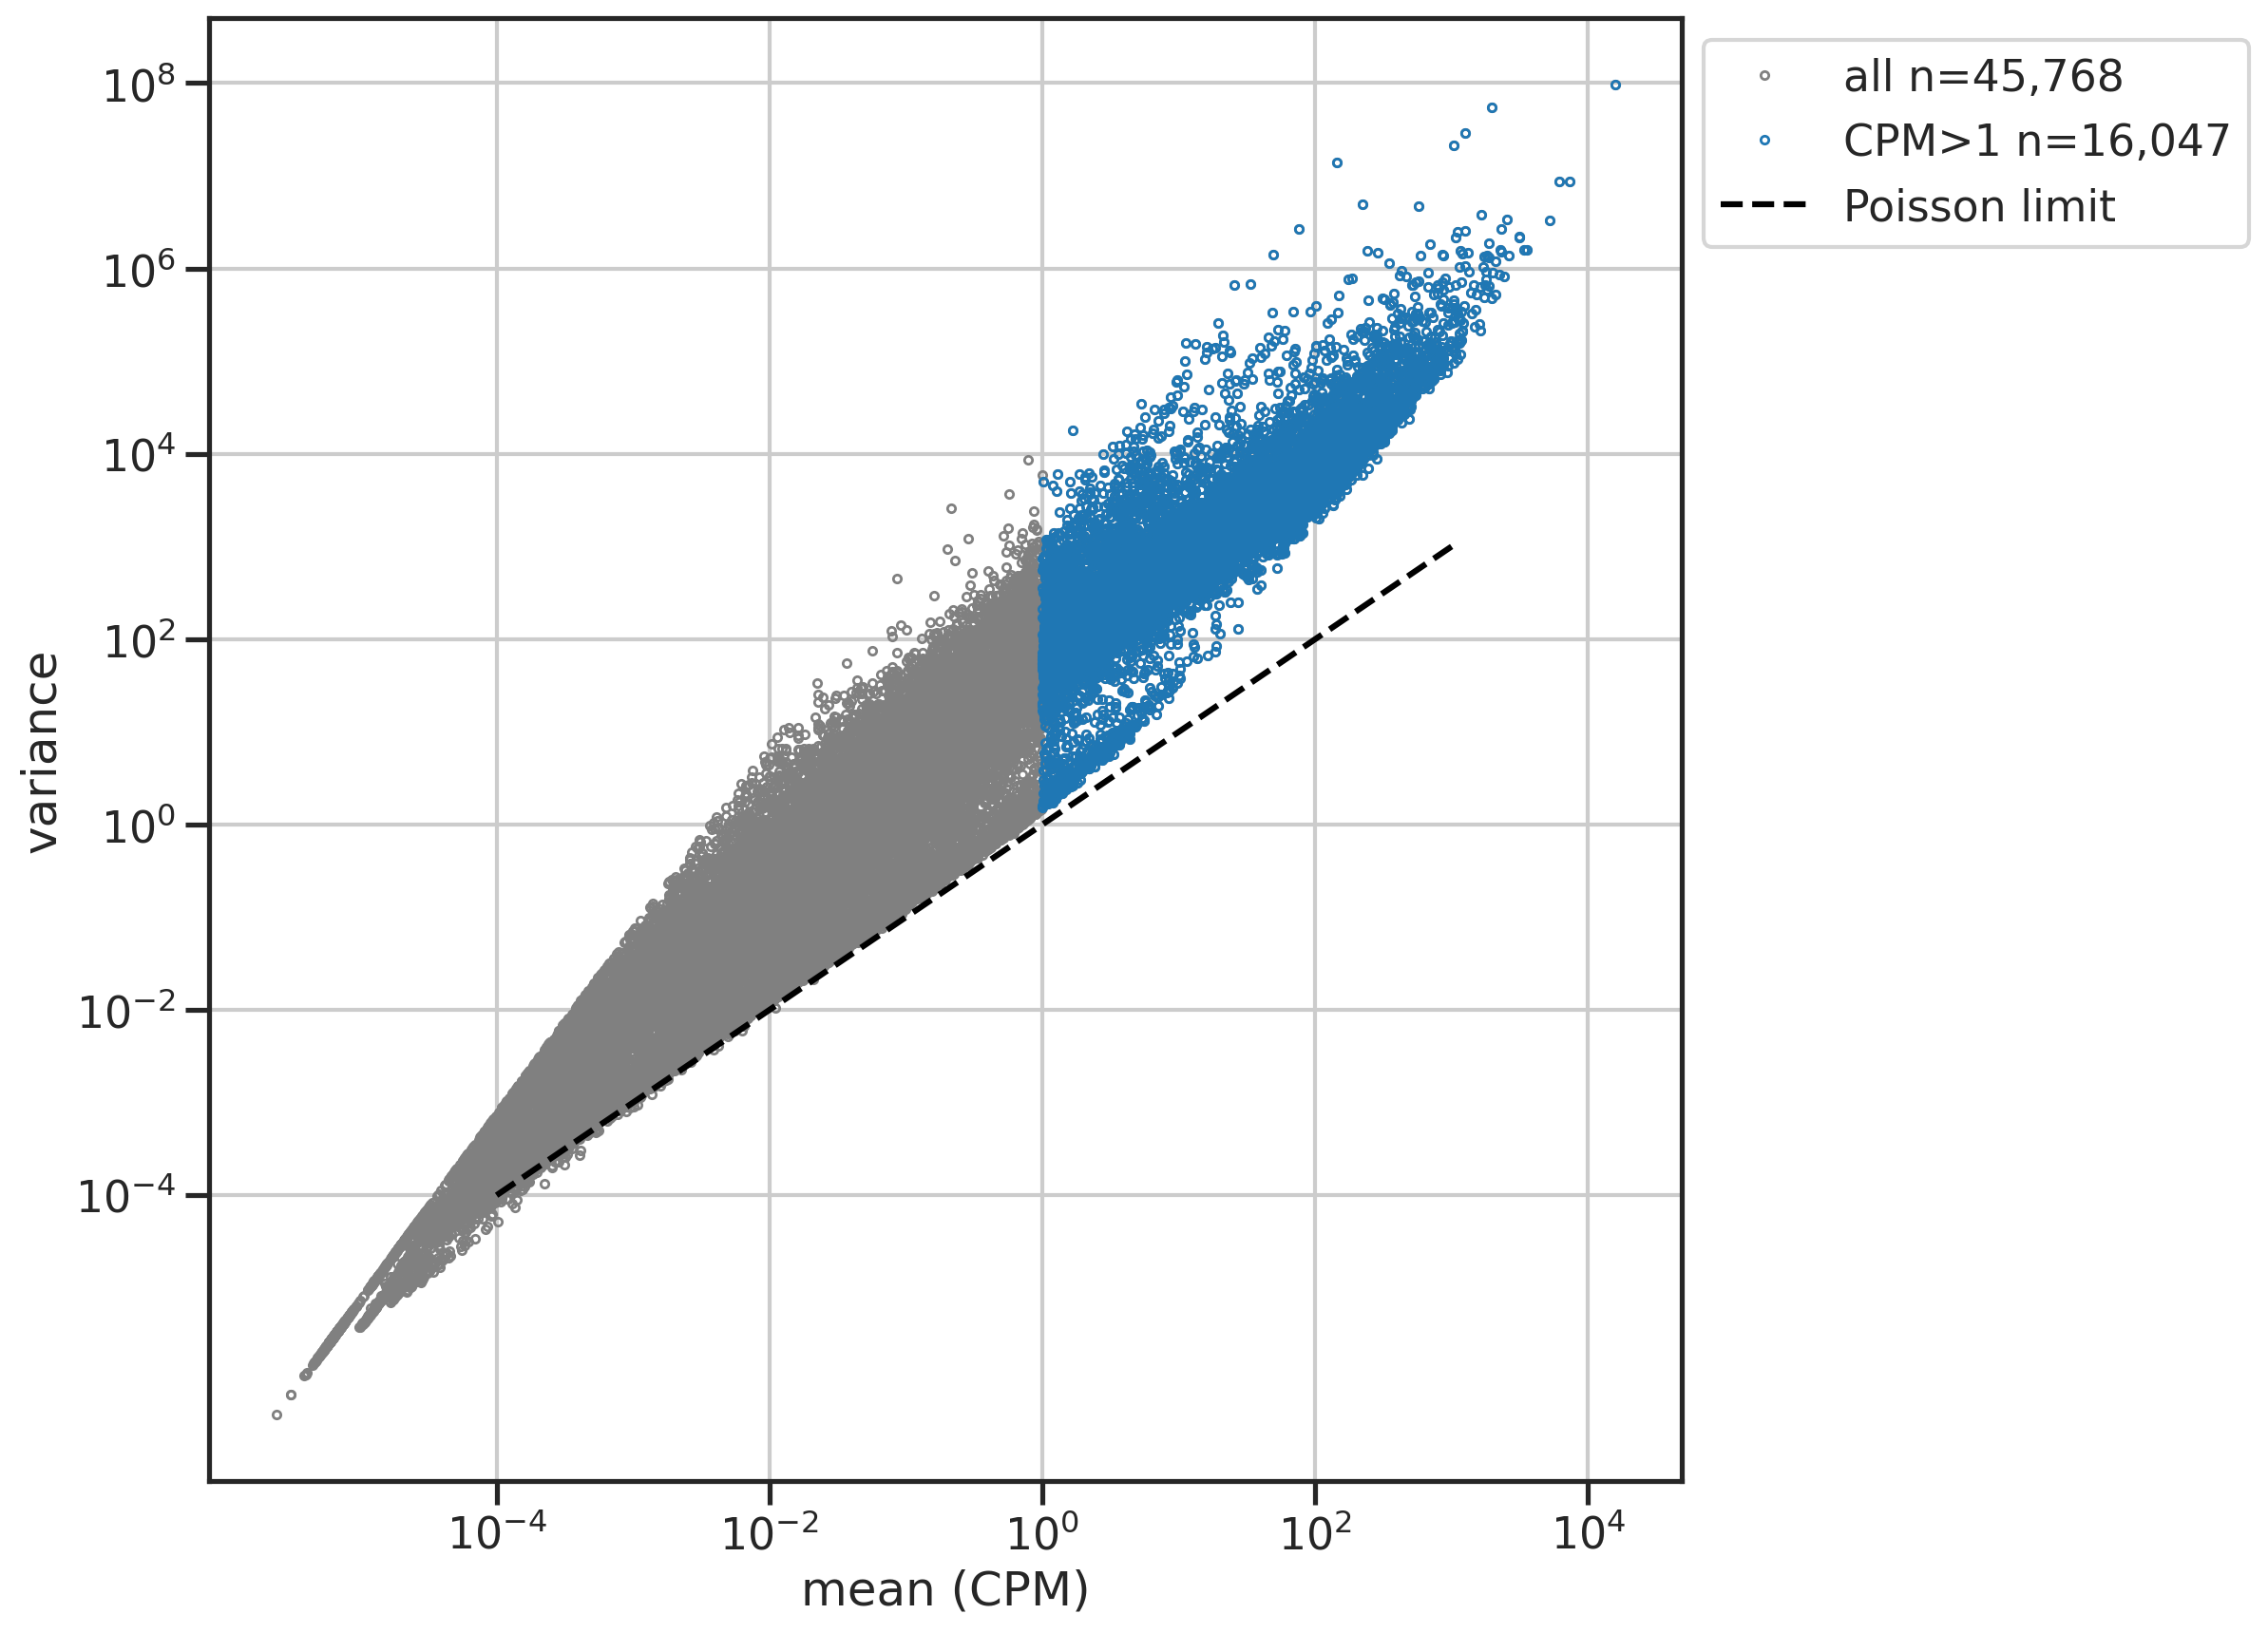

In [35]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(genes2_mean, genes2_var, 'o',
        color='gray', fillstyle='none', markersize=3, label=f'all n={len(genes_mean):,}')
cond = genes2_mean > 1
ax.plot(genes2_mean[cond], genes2_var[cond], 'o',
        color='C0', fillstyle='none', markersize=3, label=f'CPM>1 n={cond.sum():,}')
ax.plot([1e-4, 1e3], [1e-4, 1e3], '--k', label='Poisson limit')

ax.set_xlabel('mean (CPM)')
ax.set_ylabel('variance')

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_aspect('auto')

ax.set_xticks([1e-4, 1e-2, 1e0, 1e2, 1e4])
ax.set_yticks([1e-4, 1e-2, 1e0, 1e2, 1e4, 1e6, 1e8])
ax.legend(bbox_to_anchor=(1,1))
plt.show()

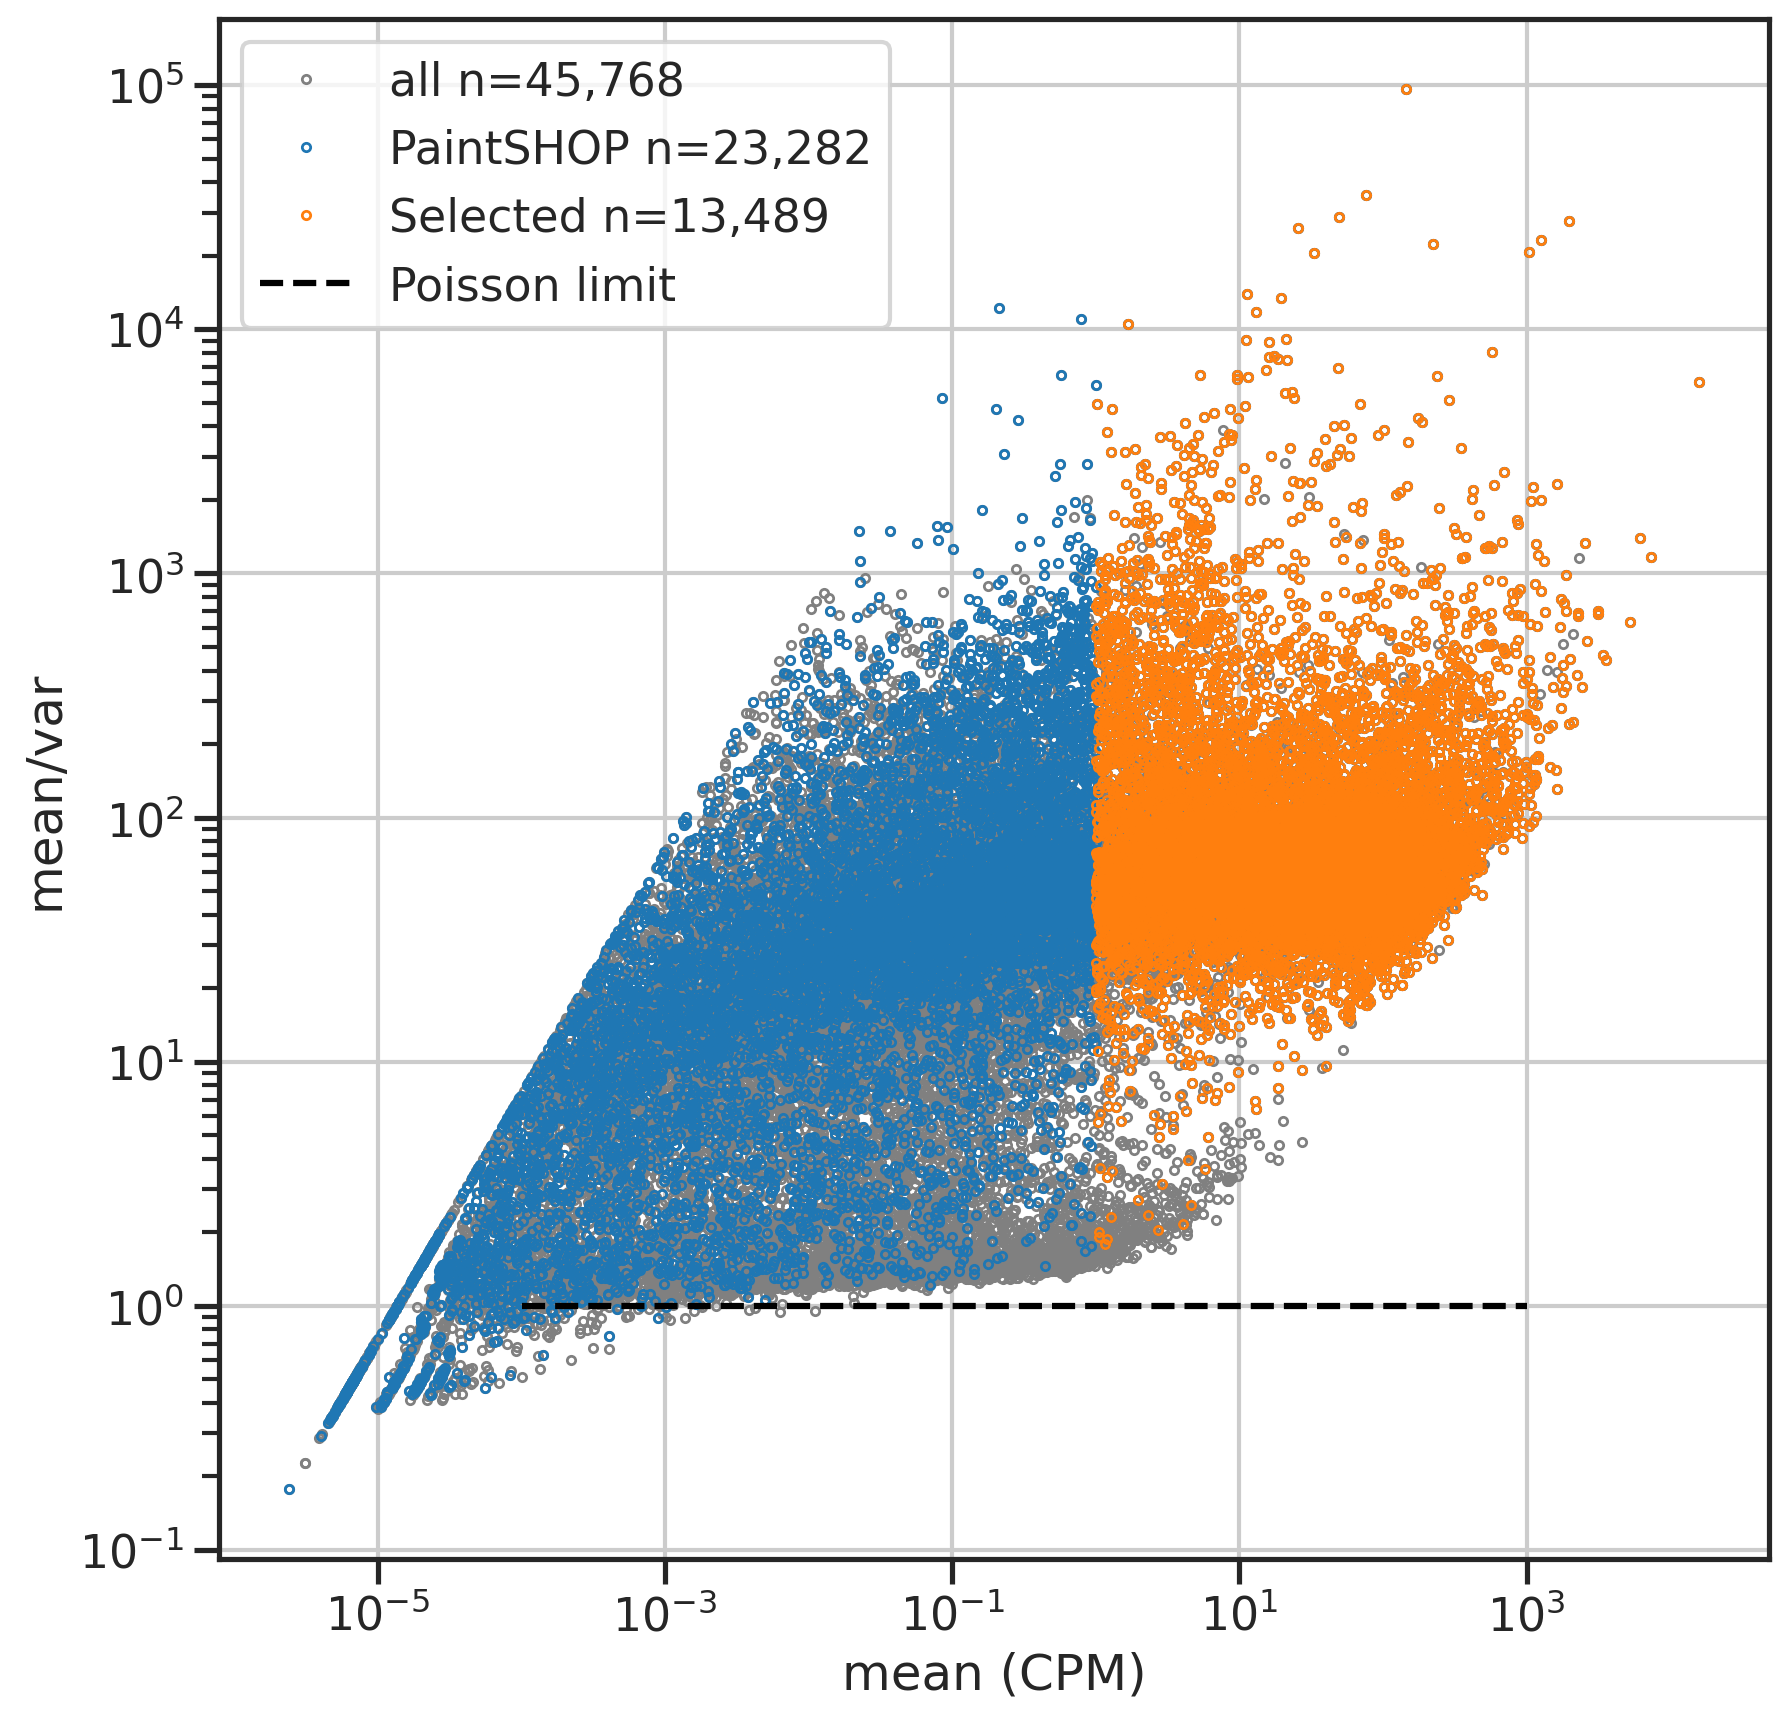

In [36]:
fig, ax = plt.subplots(figsize=(10,10))
ax.plot(genes2_mean, genes2_varmeanratio, 'o',color='gray', fillstyle='none', markersize=3, label=f'all n={len(genes_mean):,}')
# ax.plot(genes2_mean[a_unqidx], genes2_varmeanratio[a_unqidx], 'o', markersize=3, fillstyle='none', label='DPNMF only')
# ax.plot(genes2_mean[b_unqidx], genes2_varmeanratio[b_unqidx], 'o', markersize=3, fillstyle='none', label='NN only')
ax.plot(genes2_mean[c_idx], genes2_varmeanratio[c_idx], 'o', markersize=3, fillstyle='none', label=f'PaintSHOP n={len(c_idx):,}')
ax.plot(genes2_mean[s_idx], genes2_varmeanratio[s_idx], 'o', markersize=3, fillstyle='none', label=f'Selected n={len(s_idx):,}')

# ax.axhline(1, color='k')
ax.plot([1e-4, 1e3], [1, 1], '--k', label='Poisson limit')
ax.set_xlabel('mean (CPM)')
ax.set_ylabel('mean/var')
ax.set_xscale('log')
ax.set_yscale('log')
ax.legend()
plt.show()

/tmp/ipykernel_2207897/3015938181.py:1: RuntimeWarning: divide by zero encountered in log10
  sns.histplot(np.log10(genes2_mean))


Text(0, 0.5, 'Num. genes')

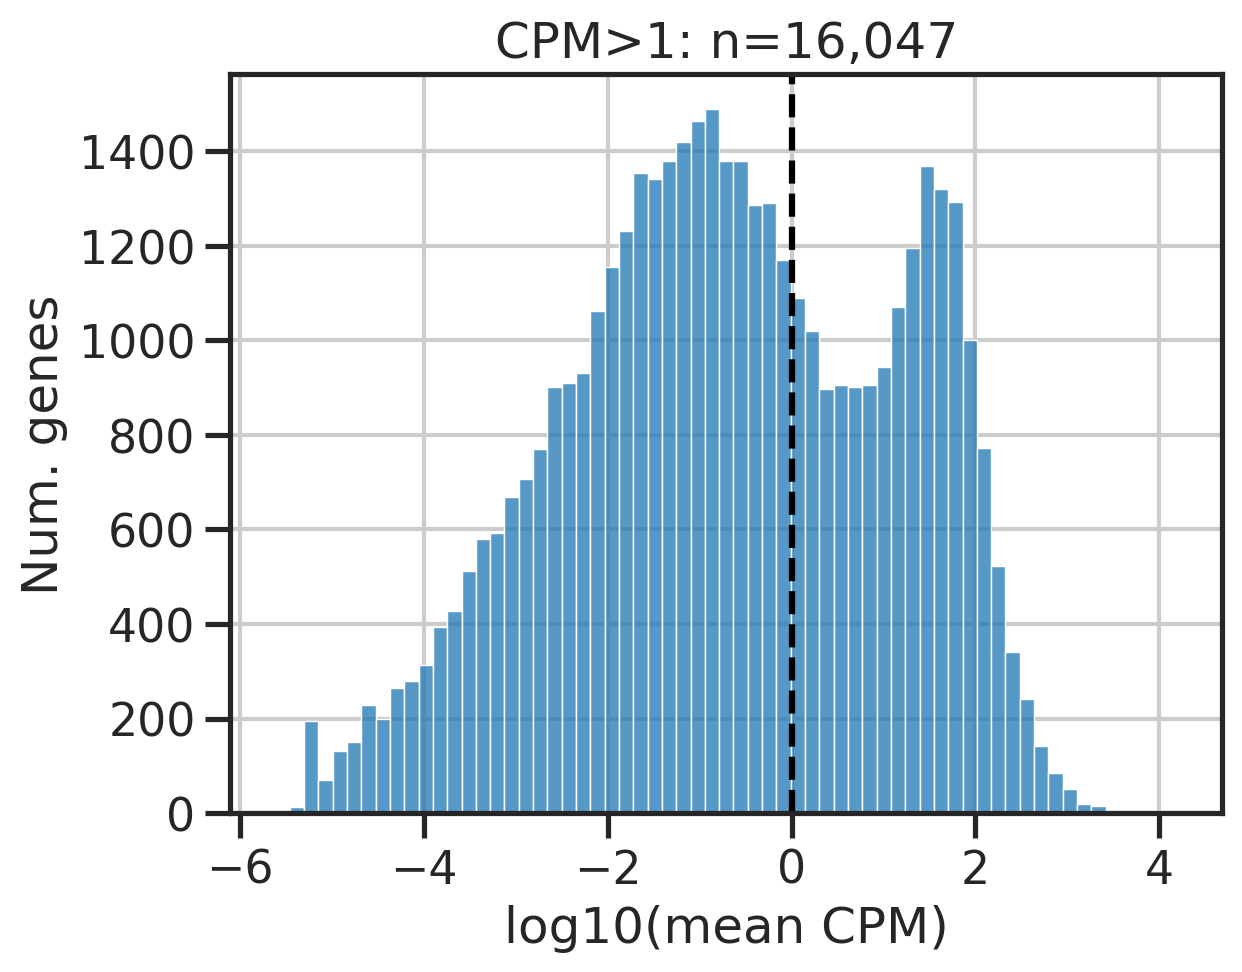

In [44]:
sns.histplot(np.log10(genes2_mean))
plt.axvline(0, color='k', linestyle='--')
plt.title(f'CPM>1: n={np.sum(genes2_mean>1):,}')
plt.xlabel('log10(mean CPM)')
plt.ylabel('Num. genes')